In [14]:
from hacca import hacca
import scanpy as sc
from hacca.data import Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# <font size=2>**set working directory** 

In [15]:
#### dir name
cwd="I:\\mutiomics\\"
data_path = os.path.join(cwd, 'data')
work_dir = os.path.join(cwd, 'work')
if not os.path.exists(work_dir):
    os.makedirs(work_dir)

# <font size=2>**Read in data** 
# <font size=1>We align b_prime to a in this case, a is MSI-MALDI and b_prime is 10X Visum.

In [16]:
a_h5ad = sc.read_h5ad(os.path.join(data_path, "m3_9AA_VisiumArray.h5ad"))
b_prime_h5ad = sc.read_h5ad(os.path.join(data_path,"m3_visium_ctrl.h5ad"))

# <font size=2>**Step 1: Data preprocession.**
# <font size=1>MSI-MALDI has a blank area, clustered as cluster 0, remove it

In [17]:
a_h5ad.obs["leiden"] = a_h5ad.obs["clusters"]
b_prime_h5ad.obs["leiden"] = b_prime_h5ad.obs["clusters"]
idx_to_remove = a_h5ad.obs["clusters"][a_h5ad.obs["clusters"] == "0"]
keep_cells_mask = ~a_h5ad.obs.index.isin(idx_to_remove.index)
a_h5ad = a_h5ad[keep_cells_mask, :]

# <font size=1>lets take a look at a and b_prime

a View of AnnData object with n_obs × n_vars = 3084 × 3658
    obs: 'clusters', 'leiden'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters', 'clusters_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
b_prime AnnData object with n_obs × n_vars = 2239 × 15249
    obs: 'in_tissue', 'array_row', 'array_col', 'mt_frac', 'total_counts', 'n_counts', 'n_genes', 'clusters', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters', 'clusters_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


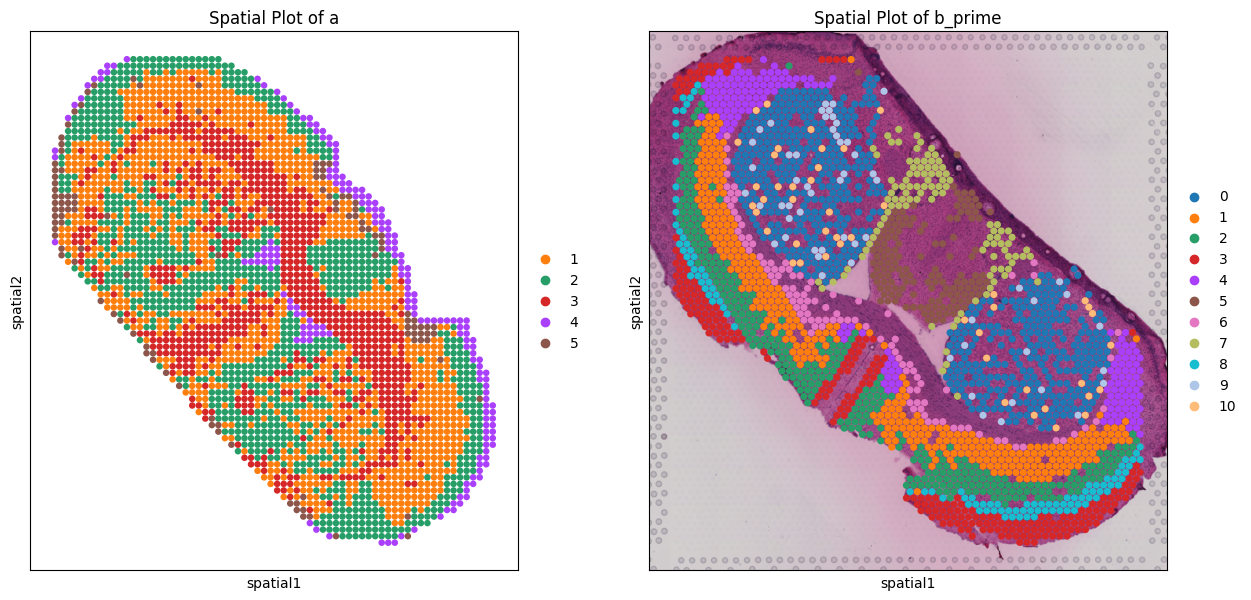

In [18]:
print("a",a_h5ad)
print("b_prime",b_prime_h5ad)
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
sc.pl.spatial(a_h5ad, img_key = "hires", color="clusters", spot_size=1, ax=axs[0], show=False)
axs[0].set_title('Spatial Plot of a')
sc.pl.spatial(b_prime_h5ad, img_key = "hires", color="clusters", size=1.5,ax=axs[1],show=False)
axs[1].set_title('Spatial Plot of b_prime')
plt.show()

# <font size=1>scale spatial data of a and b_prime,defalut[0-500]

In [19]:
b_prime_spatial = pd.DataFrame(b_prime_h5ad.obsm['spatial'])
scaledata = hacca.center_and_scale(b_prime_spatial)
b_prime_spatial = pd.DataFrame(scaledata, columns=b_prime_spatial.columns).to_numpy()
a_spatial = pd.DataFrame(a_h5ad.obsm['spatial'])
scaledata = hacca.center_and_scale(a_spatial)
a_spatial = pd.DataFrame(scaledata, columns=a_spatial.columns).to_numpy()

# <font size=1> turn a and b_prime into hacca.Data format: Data(X(n,m),D(n,2),Lable(n,1)). n is the number of spots and m is the number of features

In [20]:
a = Data(X=a_h5ad.X.toarray(), D = a_spatial, Label=a_h5ad.obs['leiden'].to_numpy())
b_prime = Data(X=b_prime_h5ad.X.toarray(), D = b_prime_spatial, Label=b_prime_h5ad.obs['leiden'].to_numpy())

# <font size=1>Ok lets hacca. This is the classic hacca, morphopogical alignment is peformed by 1.manual gross algnment and 2.further alignment.combined feature and morphological alignment is performed by ICP

# <font size=2>**Step2: gross manual alignment** 
# <font size=1> In this step, 2 windows of morphological plots will shown. You should manually choose 3 pairs of feature points by clicking. In this case, feature points is shown in red box.

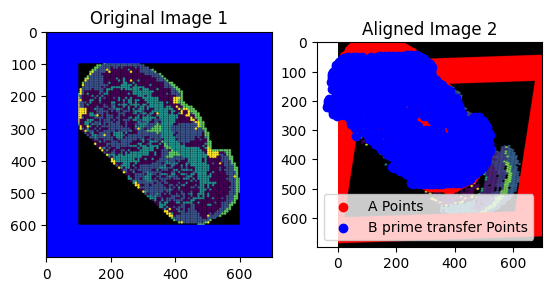

In [24]:
manual_gross_further_ICP_work_dir = os.path.join(work_dir, 'manual_gross_further')
if not os.path.exists(manual_gross_further_ICP_work_dir):
    os.makedirs(manual_gross_further_ICP_work_dir)
_b_prime = hacca.manual_gross_alignment(a, b_prime, work_dir=manual_gross_further_ICP_work_dir)

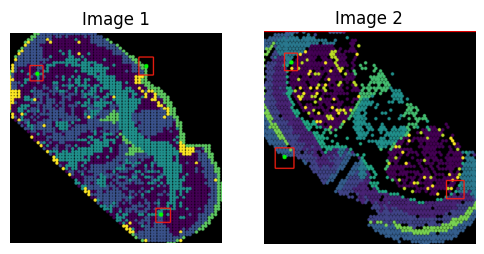

# <font size=2>**Step3: further alignment**

In [25]:
_b_prime = hacca.further_alignment(a, _b_prime)

I:\mutiomics\pythonProject\.venv\lib\site-packages\hacca\hacca.py:284: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_C_.loc[:,'BprimeID'] = values
I:\mutiomics\pythonProject\.venv\lib\site-packages\hacca\hacca.py:293: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z_C_.loc[:,'AID'] = values


# <font size=2>**Step4: combined feature and morphological alignment**

In [ ]:
_a, _b_prime = hacca.icp_2d_with_feature_alignment(a, _b_prime)

I:\mutiomics\pythonProject\.venv\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
I:\mutiomics\pythonProject\.venv\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


# <font size=1> b_predict is the aligned b_prime, lets see b_predict

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


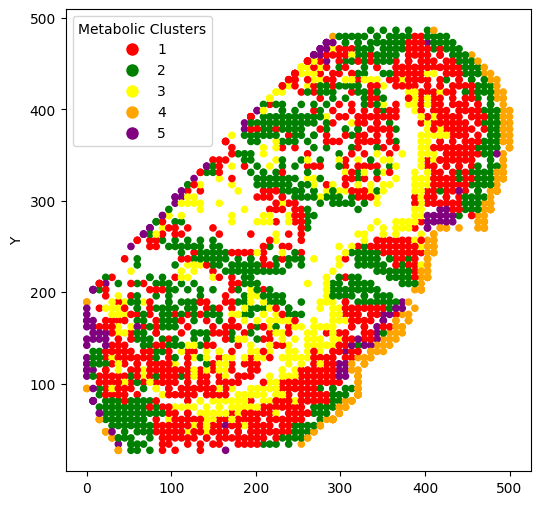

In [27]:
b_predict = hacca.direct_alignment(_a, _b_prime, work_dir=manual_gross_further_ICP_work_dir)
hacca.plot_b_predict(b_predict,manual_gross_further_ICP_work_dir)

# <font size=2>**Step5: merge b_prime and b_predict to generate a new merge_adata**

In [28]:
Label_merge = np.vstack((b_prime.Label,b_predict.Label)).T
Label_merge = pd.DataFrame(Label_merge,columns=["b_prime_label","a_label"])
X_merge = np.hstack((b_prime.X,b_predict.X))
merge_var = np.hstack((b_prime_h5ad.var_names, a_h5ad.var_names))
merge_var = pd.DataFrame(index=merge_var)
merge_adata = sc.AnnData(X=X_merge, var=merge_var, obs=Label_merge)
merge_adata.obsm=b_prime_h5ad.obsm
merge_adata.uns =b_prime_h5ad.uns

I:\mutiomics\pythonProject\.venv\lib\site-packages\anndata\_core\aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


# <font size=1> Now haCCA is finished. Lets take a look at b_prime and a's label distribution in merge_adata

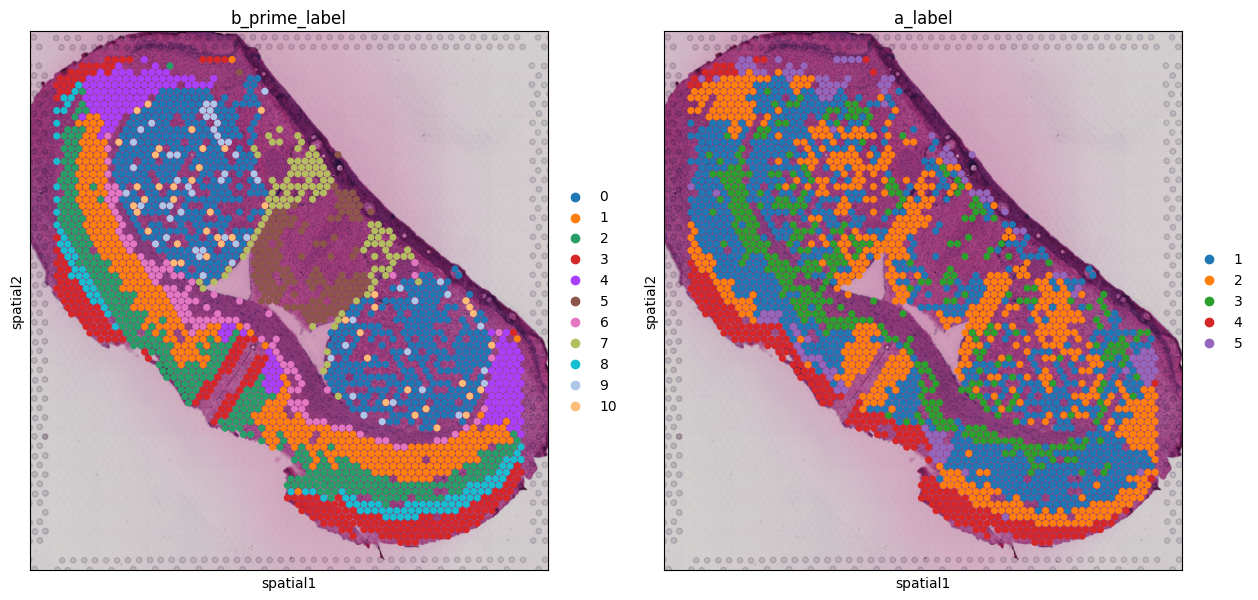

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
sc.pl.spatial(merge_adata, img_key = "hires", color="b_prime_label", size=1.5,ax=axs[0],show=False)
axs[0].set_title('b_prime_label')
sc.pl.spatial(merge_adata, img_key = "hires", color="a_label", size=1.5,ax=axs[1],show=False)
axs[1].set_title('a_label')
plt.show()

# <font size=1> Lets take a look at b_prime and a's label distribution in merge_adata. 
# <font size=1> We select gene "Vxn" from b_prime and metabolite "881.51323" from a


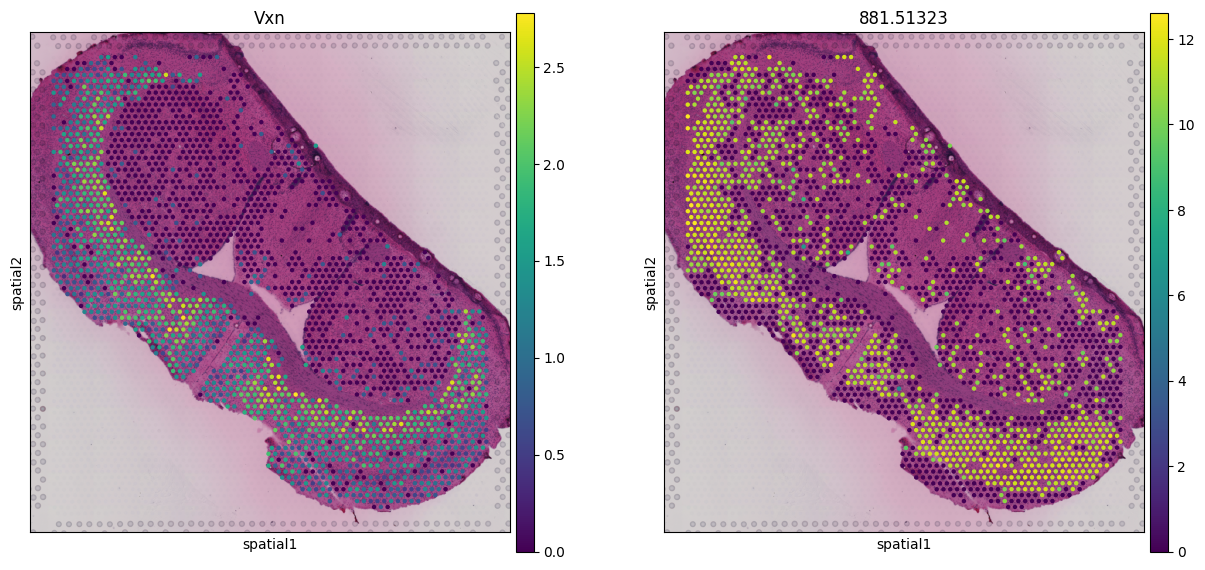

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
sc.pl.spatial(merge_adata,color="Vxn",title="Vxn",size=1,show=False, alpha_img=1,ax=axs[0])
sc.pl.spatial(merge_adata,color="881.51323",title="881.51323",size=1,show=False, alpha_img=1,ax=axs[1])
plt.show()
